# U-Net Arquitectura Básica

Vamos a constuir una arquitecutra U-Net básica (con y sin dropout) para realizar segmentación semántica del dataset Data Science Bowl (2018) que contiene imágenes de tejido biológico dónde se han obtenido mascaras de los nucleos celulares. Usaremos U-net para realizar la segmentación semántica, contruiremos un modelo básico, y luego una modificación con Dropout. El tamaño de las imágenes de entrada será 128x128.

[Enlace Dataset](https://www.kaggle.com/c/data-science-bowl-2018/data)

[Paper Original](https://arxiv.org/pdf/1505.04597.pdf)

## 1. Importamos librerías

In [2]:
import os
import numpy as np
from tqdm import tqdm 
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import datetime

# Librerias para constuir la arquitectura U-Net
from tensorflow.keras.layers import Input, Lambda, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

## 2. Definimos configuración básica

In [3]:
width_shape, height_shape = 128, 128 # Tamaño de las imagenes de entrada
batch_size = 16
epochs = 200
data_path_train = "radiografias/"    # Directorio de las imágenes y mascaras de entrenamiento
data_path_masks = "mascaras/"      # Directorio de las imágenes de pruebas
data_path_test= "test/"

## 3. Adecuamos el dataset

In [4]:
# obtenemos una lista con los archivos dentro de cada carpeta
data_list_train = os.listdir(data_path_train)
data_list_masks = os.listdir(data_path_masks)
data_list_test = os.listdir(data_path_test)

# Definimos listas para guardar cada elemento del dataset
Xtrain=[] 
Ymasks=[]
Xtest=[]
# Process training images
for file in tqdm(data_list_train, desc="Processing train images"):
    img_path = os.path.join(data_path_train, file)
    
    # Leer la imagen
    img = imread(img_path)
    
    # Verificar el número de canales de la imagen
    if img.ndim == 2:
        # Imagen en escala de grises: convertir a RGB
        img = np.stack([img] * 3, axis=-1)
    elif img.ndim == 3 and img.shape[2] == 4:
        # Imagen RGBA: convertir a RGB (descartar canal alfa)
        img = img[:,:,:3]
    elif img.ndim == 3 and img.shape[2] > 3:
        # Imagen con más de 3 canales: seleccionar solo los primeros 3 canales
        img = img[:,:,:3]

    # Redimensionar la imagen
    img = resize(img, (height_shape, width_shape), mode='constant', preserve_range=True)
    
    # Agregar la imagen procesada a la lista
    Xtrain.append(img)

# Process mask images
for file in tqdm(data_list_masks, desc="Processing masks"):
    # Read the mask as grayscale
    mask = imread(os.path.join(data_path_masks, file), as_gray=True)
    
    # Resize the mask
    mask = resize(mask, (height_shape, width_shape), mode='constant', preserve_range=True)
    
    # Ensure the mask is binary
    mask = (mask > 0.5).astype(np.float32)
    
    # Add channel dimension
    mask = np.expand_dims(mask, axis=-1)
    
    Ymasks.append(mask)


# Process test images
for file in tqdm(data_list_test, desc="Processing test images"):
    img = imread(os.path.join(data_path_test, file))
    
    # Verificar las dimensiones de la imagen
    if img.ndim == 2:  # Imagen en escala de grises
        img = np.stack([img] * 3, axis=-1)  # Convertir a RGB
    elif img.ndim == 3 and img.shape[2] == 4:  # Si es RGBA, descartar canal alfa
        img = img[:,:,:3]
    elif img.ndim == 3 and img.shape[2] > 3:  # Si tiene más de 3 canales, solo toma los primeros 3
        img = img[:,:,:3]

    # Redimensionar la imagen
    img = resize(img, (height_shape, width_shape), mode='constant', preserve_range=True)
    
    Xtest.append(img)
    
X_train = np.asarray(Xtrain,dtype=np.uint8)
print('Xtrain:',X_train.shape)

Y_masks = np.asarray(Ymasks,dtype=np.bool)
print('Ymasks:',Y_masks.shape)

X_test = np.asarray(Xtest, dtype=np.uint8)
print('Xtest:', X_test.shape)

Processing test images:   5%|██▊                                                        | 3/62 [00:00<00:02, 26.34it/s]

Processed image shape: (128, 128, 3)
Processed image shape: (128, 128, 3)
Processed image shape: (128, 128, 3)
Processed image shape: (128, 128, 3)
Processed image shape: (128, 128, 3)


Processing test images:  10%|█████▋                                                     | 6/62 [00:00<00:06,  8.53it/s]

Processed image shape: (128, 128, 3)
Processed image shape: (128, 128, 3)


Processing test images:  13%|███████▌                                                   | 8/62 [00:01<00:09,  5.90it/s]

Processed image shape: (128, 128, 3)


Processing test images:  15%|████████▌                                                  | 9/62 [00:01<00:09,  5.38it/s]

Processed image shape: (128, 128, 3)


Processing test images:  16%|█████████▎                                                | 10/62 [00:01<00:10,  5.01it/s]

Processed image shape: (128, 128, 3)


Processing test images:  18%|██████████▎                                               | 11/62 [00:01<00:10,  4.71it/s]

Processed image shape: (128, 128, 3)


Processing test images:  19%|███████████▏                                              | 12/62 [00:02<00:11,  4.37it/s]

Processed image shape: (128, 128, 3)


Processing test images:  21%|████████████▏                                             | 13/62 [00:02<00:11,  4.26it/s]

Processed image shape: (128, 128, 3)


Processing test images:  24%|██████████████                                            | 15/62 [00:02<00:10,  4.33it/s]

Processed image shape: (128, 128, 3)
Processed image shape: (128, 128, 3)


Processing test images:  26%|██████████████▉                                           | 16/62 [00:03<00:10,  4.26it/s]

Processed image shape: (128, 128, 3)


Processing test images:  27%|███████████████▉                                          | 17/62 [00:03<00:10,  4.20it/s]

Processed image shape: (128, 128, 3)


Processing test images:  29%|████████████████▊                                         | 18/62 [00:03<00:10,  4.14it/s]

Processed image shape: (128, 128, 3)


Processing test images:  34%|███████████████████▋                                      | 21/62 [00:03<00:06,  6.38it/s]

Processed image shape: (128, 128, 3)
Processed image shape: (128, 128, 3)
Processed image shape: (128, 128, 3)


Processing test images:  35%|████████████████████▌                                     | 22/62 [00:04<00:08,  4.98it/s]

Processed image shape: (128, 128, 3)


Processing test images:  37%|█████████████████████▌                                    | 23/62 [00:04<00:08,  4.62it/s]

Processed image shape: (128, 128, 3)


Processing test images:  39%|██████████████████████▍                                   | 24/62 [00:04<00:08,  4.42it/s]

Processed image shape: (128, 128, 3)


Processing test images:  40%|███████████████████████▍                                  | 25/62 [00:05<00:08,  4.30it/s]

Processed image shape: (128, 128, 3)


Processing test images:  42%|████████████████████████▎                                 | 26/62 [00:05<00:08,  4.12it/s]

Processed image shape: (128, 128, 3)


Processing test images:  44%|█████████████████████████▎                                | 27/62 [00:05<00:08,  4.10it/s]

Processed image shape: (128, 128, 3)


Processing test images:  45%|██████████████████████████▏                               | 28/62 [00:05<00:08,  4.08it/s]

Processed image shape: (128, 128, 3)


Processing test images:  47%|███████████████████████████▏                              | 29/62 [00:06<00:08,  4.06it/s]

Processed image shape: (128, 128, 3)
Processed image shape: (128, 128, 3)
Processed image shape: (128, 128, 3)


Processing test images:  53%|██████████████████████████████▊                           | 33/62 [00:06<00:04,  6.97it/s]

Processed image shape: (128, 128, 3)
Processed image shape: (128, 128, 3)


Processing test images:  56%|████████████████████████████████▋                         | 35/62 [00:06<00:04,  6.26it/s]

Processed image shape: (128, 128, 3)
Processed image shape: (128, 128, 3)


Processing test images:  60%|██████████████████████████████████▌                       | 37/62 [00:07<00:03,  6.59it/s]

Processed image shape: (128, 128, 3)
Processed image shape: (128, 128, 3)


Processing test images:  63%|████████████████████████████████████▍                     | 39/62 [00:07<00:03,  6.97it/s]

Processed image shape: (128, 128, 3)
Processed image shape: (128, 128, 3)


Processing test images:  66%|██████████████████████████████████████▎                   | 41/62 [00:07<00:02,  7.21it/s]

Processed image shape: (128, 128, 3)
Processed image shape: (128, 128, 3)


Processing test images:  69%|████████████████████████████████████████▏                 | 43/62 [00:07<00:02,  7.07it/s]

Processed image shape: (128, 128, 3)
Processed image shape: (128, 128, 3)


Processing test images:  71%|█████████████████████████████████████████▏                | 44/62 [00:08<00:02,  7.08it/s]

Processed image shape: (128, 128, 3)


Processing test images:  74%|███████████████████████████████████████████               | 46/62 [00:08<00:02,  6.18it/s]

Processed image shape: (128, 128, 3)
Processed image shape: (128, 128, 3)


Processing test images:  77%|████████████████████████████████████████████▉             | 48/62 [00:08<00:02,  6.95it/s]

Processed image shape: (128, 128, 3)
Processed image shape: (128, 128, 3)


Processing test images:  81%|██████████████████████████████████████████████▊           | 50/62 [00:08<00:01,  7.26it/s]

Processed image shape: (128, 128, 3)
Processed image shape: (128, 128, 3)


Processing test images:  84%|████████████████████████████████████████████████▋         | 52/62 [00:09<00:01,  7.15it/s]

Processed image shape: (128, 128, 3)
Processed image shape: (128, 128, 3)


Processing test images:  87%|██████████████████████████████████████████████████▌       | 54/62 [00:09<00:01,  7.24it/s]

Processed image shape: (128, 128, 3)
Processed image shape: (128, 128, 3)


Processing test images:  89%|███████████████████████████████████████████████████▍      | 55/62 [00:09<00:00,  7.35it/s]

Processed image shape: (128, 128, 3)


Processing test images:  92%|█████████████████████████████████████████████████████▎    | 57/62 [00:10<00:00,  6.01it/s]

Processed image shape: (128, 128, 3)
Processed image shape: (128, 128, 3)


Processing test images:  95%|███████████████████████████████████████████████████████▏  | 59/62 [00:10<00:00,  7.37it/s]

Processed image shape: (128, 128, 3)
Processed image shape: (128, 128, 3)


Processing test images:  98%|█████████████████████████████████████████████████████████ | 61/62 [00:10<00:00,  6.41it/s]

Processed image shape: (128, 128, 3)
Processed image shape: (128, 128, 3)


Processing test images: 100%|██████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.74it/s]

Processed image shape: (128, 128, 3)
Xtrain: (558, 128, 128, 3)
Ymasks: (558, 128, 128, 1)
Xtest: (62, 128, 128, 3)



D:\AnacondaReal\envs\Unet\lib\site-packages\ipykernel_launcher.py:74: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


## 4. Mostramos algún elemento del dataset

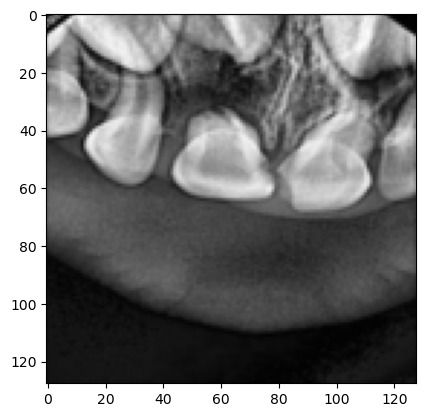

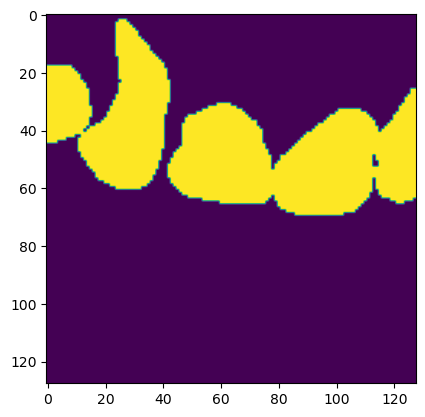

In [4]:
# Mostramos la imagen y su mascara asociada
plt.imshow(X_train[25])
plt.show()
plt.imshow(np.squeeze(Y_masks[25]))
plt.show()

## 5. Creamos un modelo básico de U-Net

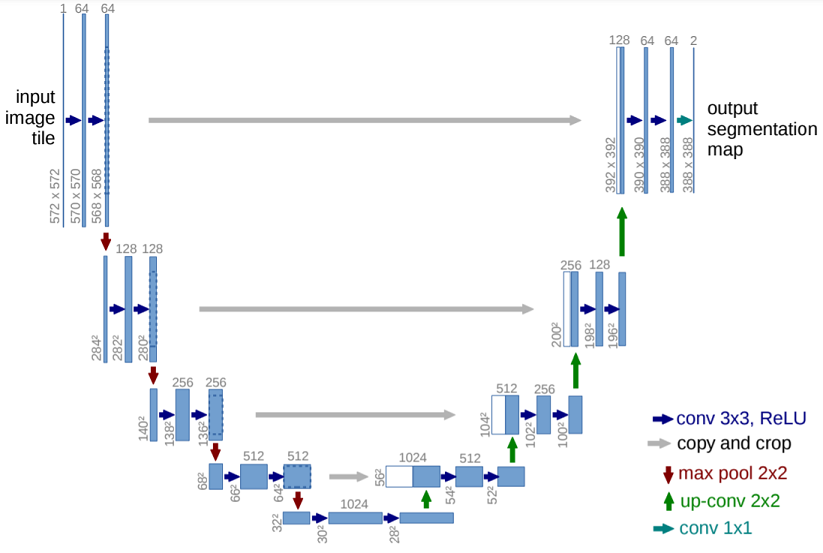

In [5]:
# Definimos la entrada al modelo
Image_input = Input((height_shape, width_shape, 3))
Image_in = Lambda(lambda x: x / 255)(Image_input)

#contracting path
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(Image_in)
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
maxp1 = MaxPooling2D((2, 2))(conv1)

conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(maxp1)
conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
maxp2 = MaxPooling2D((2, 2))(conv2)
 
conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(maxp2)
conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
maxp3 = MaxPooling2D((2, 2))(conv3)
 
conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(maxp3)
conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
maxp4 = MaxPooling2D(pool_size=(2, 2))(conv4)
 
conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(maxp4)
conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

#expansive path
up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5)
up6 = concatenate([up6, conv4])
conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)
 
up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
up7 = concatenate([up7, conv3])
conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)
 
up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
up8 = concatenate([up8, conv2])
conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)
 
up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
up9 = concatenate([up9, conv1], axis=3)
conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)
 
outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
 
model = Model(inputs=[Image_input], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 1792        lambda[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 36928       conv2d[0][0]                     
______________________________________________________________________________________________

## 6. Creamos un modelo U-Net con Dropout

In [13]:
# Definimos la entrada al modelo

inputs = Lambda(lambda x: x / 255)(Input((height_shape, width_shape, 3)))

#contracting path
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Dropout(0.1)(conv1)
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
maxp1 = MaxPooling2D((2, 2))(conv1)

conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(maxp1)
conv2 = Dropout(0.1)(conv2)
conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
maxp2 = MaxPooling2D((2, 2))(conv2)
 
conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(maxp2)
conv3 = Dropout(0.2)(conv3)
conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
maxp3 = MaxPooling2D((2, 2))(conv3)
 
conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(maxp3)
conv4 = Dropout(0.2)(conv4)
conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
maxp4 = MaxPooling2D(pool_size=(2, 2))(conv4)
 
conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(maxp4)
conv5 = Dropout(0.3)(conv5)
conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)


up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5)
up6 = concatenate([up6, conv4])
conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
conv6 = Dropout(0.2)(conv6)
conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)
 
up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
up7 = concatenate([up7, conv3])
conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
conv7 = Dropout(0.2)(conv7)
conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)
 
up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
up8 = concatenate([up8, conv2])
conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
conv8 = Dropout(0.1)(conv8)
conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)
 
up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
up9 = concatenate([up9, conv1], axis=3)
conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
conv9 = Dropout(0.1)(conv9)
conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)
 
outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
 
model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: lambda_4/Identity:0


ValueError: Graph disconnected: cannot obtain value for tensor Tensor("input_5:0", shape=(None, 128, 128, 3), dtype=float32) at layer "input_5". The following previous layers were accessed without issue: []

## 7. Configuramos Tensorboard

In [6]:
from tensorflow.keras.callbacks import TensorBoard

# Cargamos la extensión, definimos la carpeta logs para guardar los datos de entrenamiento, y definimos el callback
%load_ext tensorboard
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

## 8. Entrenamos el modelo

In [7]:
results = model.fit(X_train, Y_masks, validation_split=0.1,
                     batch_size=batch_size, epochs=200, 
                     callbacks=[tensorboard_callback])

Train on 502 samples, validate on 56 samples
Epoch 1/100
502/502 [==============================] - 32s 65ms/sample - loss: 0.6396 - accuracy: 0.6613 - val_loss: 0.3978 - val_accuracy: 0.8009
Epoch 2/100
502/502 [==============================] - 13s 26ms/sample - loss: 0.5121 - accuracy: 0.7438 - val_loss: 0.3924 - val_accuracy: 0.8082
Epoch 3/100
502/502 [==============================] - 13s 26ms/sample - loss: 0.5048 - accuracy: 0.7518 - val_loss: 0.5116 - val_accuracy: 0.6714
Epoch 4/100
502/502 [==============================] - 13s 26ms/sample - loss: 0.5012 - accuracy: 0.7433 - val_loss: 0.3738 - val_accuracy: 0.8312
Epoch 5/100
502/502 [==============================] - 13s 26ms/sample - loss: 0.4800 - accuracy: 0.7556 - val_loss: 0.3838 - val_accuracy: 0.8123
Epoch 6/100
502/502 [==============================] - 13s 26ms/sample - loss: 0.4749 - accuracy: 0.7615 - val_loss: 0.4769 - val_accuracy: 0.6925
Epoch 7/100
502/502 [==============================] - 13s 26ms/sample - 

In [51]:
print("New X_train shape:", X_train.shape)

New Y_masks shape: (35, 128, 128, 3)


In [52]:
print("New Y_masks shape:", Y_masks.shape)

New Y_masks shape: (35, 128, 128, 3, 1)


## 9. Revisamos gráficas de entrenamiento

In [8]:
%reload_ext tensorboard
%tensorboard --logdir logs --host localhost

Reusing TensorBoard on port 6006 (pid 21316), started 13:53:37 ago. (Use '!kill 21316' to kill it.)

## 10. Probamos el modelo con alguna imagen de prueba

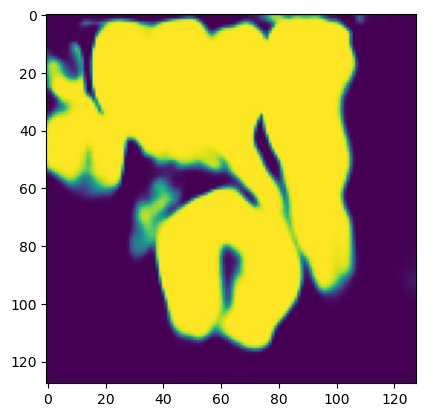

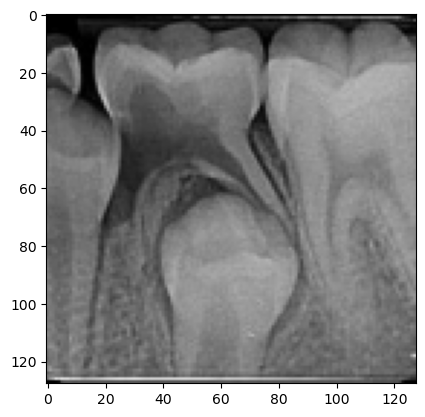

In [5]:
import os
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np

# Cargar el modelo
model = load_model("unet3_modelo")

preds = model.predict(X_test, batch_size=1)
plt.imshow(np.squeeze(preds[62]))
plt.show()
plt.imshow(X_test[62])
plt.show()

In [15]:
model.save("unet3_modelo.h5")

In [7]:
import os
import numpy as np
from sklearn.metrics import jaccard_score, f1_score
from PIL import Image

def load_image(image_path, target_size=(512, 512)):
    """
    Carga una imagen desde una ruta dada, la redimensiona y la convierte en un array binario de numpy.
    
    Parámetros:
    image_path: str
        La ruta de la imagen.
    target_size: tuple
        Tamaño al que redimensionar la imagen (ancho, alto).

    Retorna:
    np.array
        Imagen binaria en formato numpy array.
    """
    img = Image.open(image_path).convert('L')  # Convertir a escala de grises
    img = img.resize(target_size, Image.NEAREST)  # Redimensionar la imagen
    img = np.array(img)
    img = (img > 128).astype(np.uint8)  # Convertir a binaria (0 o 1) si los valores son mayores a 128
    return img

def calculate_metrics(y_true, y_pred):
    """
    Calcula el coeficiente de Jaccard (IoU) y el coeficiente de Dice.
    
    Parámetros:
    y_true: np.array
        Máscara real (ground truth).
    y_pred: np.array
        Máscara predicha.

    Retorna:
    iou: float
        Coeficiente de Jaccard (IoU).
    dice: float
        Coeficiente de Dice.
    """
    # Aplanamos las imágenes para poder calcular las métricas
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    # Coeficiente de Jaccard (IoU)
    iou = jaccard_score(y_true_flat, y_pred_flat, average='binary')

    # Coeficiente de Dice (F1-score para problemas binarios)
    dice = f1_score(y_true_flat, y_pred_flat, average='binary')

    return iou, dice

# Rutas de las carpetas donde están las máscaras originales y las predicciones
ground_truth_folder = 'MascarasOriginales'
predictions_folder = 'mascaras3_modelo'

# Obtener la lista de archivos en cada carpeta (se asume que tienen los mismos nombres)
ground_truth_files = sorted(os.listdir(ground_truth_folder))
prediction_files = sorted(os.listdir(predictions_folder))

# Iterar sobre los archivos y calcular métricas
ious = []
dices = []

for gt_file, pred_file in zip(ground_truth_files, prediction_files):
    # Crear la ruta completa de cada archivo
    gt_path = os.path.join(ground_truth_folder, gt_file)
    pred_path = os.path.join(predictions_folder, pred_file)
    
    # Cargar las imágenes
    y_true = load_image(gt_path)
    y_pred = load_image(pred_path)
    
    # Calcular métricas
    iou, dice = calculate_metrics(y_true, y_pred)
    
    # Guardar los resultados
    ious.append(iou)
    dices.append(dice)
    
    print(f"Archivo: {gt_file}")
    print(f"IoU (Jaccard): {iou}")
    print(f"Coeficiente de Dice: {dice}\n")

# Opcional: calcular la media de todas las métricas
print(f"Promedio IoU: {np.mean(ious)}")
print(f"Promedio Coeficiente de Dice: {np.mean(dices)}")


Archivo: diente_1.jpeg
IoU (Jaccard): 0.49541336815473763
Coeficiente de Dice: 0.6625771558616624

Archivo: diente_10.jpeg
IoU (Jaccard): 0.42820774623919405
Coeficiente de Dice: 0.5996435005576262

Archivo: diente_11.jpeg
IoU (Jaccard): 0.14867146320635263
Coeficiente de Dice: 0.25885811212086257

Archivo: diente_12.jpeg
IoU (Jaccard): 0.538111843846747
Coeficiente de Dice: 0.6997044408694677

Archivo: diente_13.jpeg
IoU (Jaccard): 0.22314798556790955
Coeficiente de Dice: 0.3648748772852724

Archivo: diente_14.jpeg
IoU (Jaccard): 0.17206461535726034
Coeficiente de Dice: 0.2936094360374711

Archivo: diente_15.jpeg
IoU (Jaccard): 0.2448580790335952
Coeficiente de Dice: 0.39339115543786773

Archivo: diente_16.jpeg
IoU (Jaccard): 0.43680880944507194
Coeficiente de Dice: 0.6080263519734088

Archivo: diente_17.jpeg
IoU (Jaccard): 0.48860494725354675
Coeficiente de Dice: 0.6564601953728764

Archivo: diente_18.jpeg
IoU (Jaccard): 0.5513829568979988
Coeficiente de Dice: 0.7108276579246338

Arc

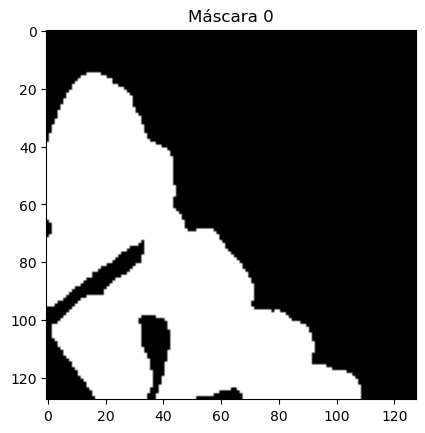

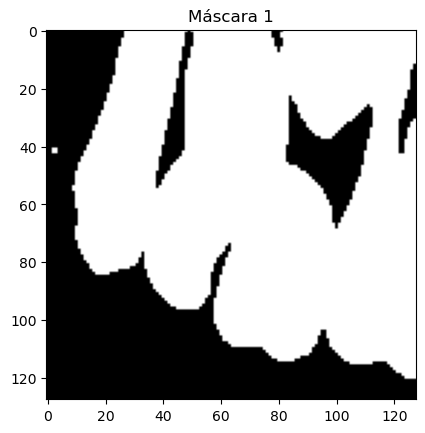

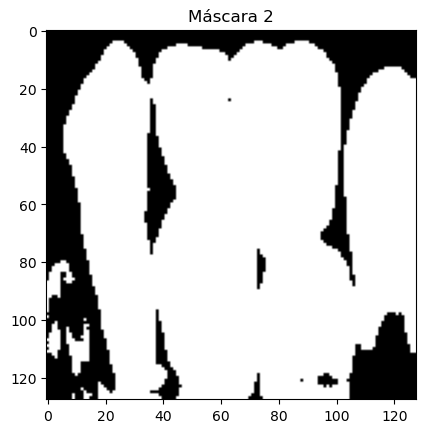

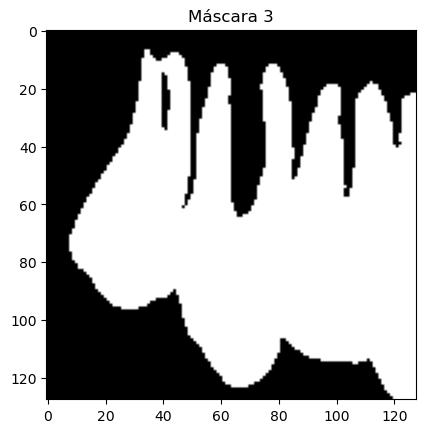

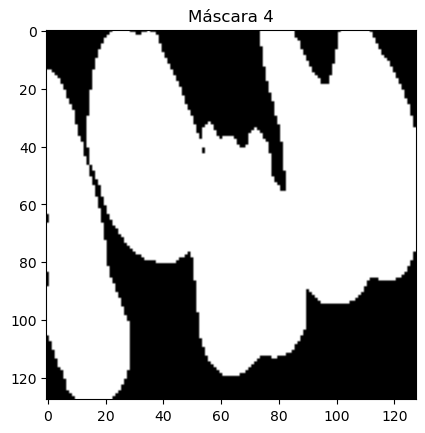

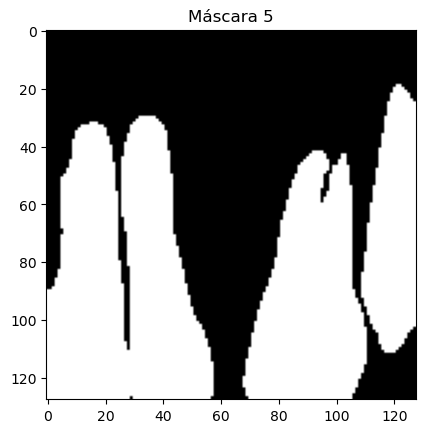

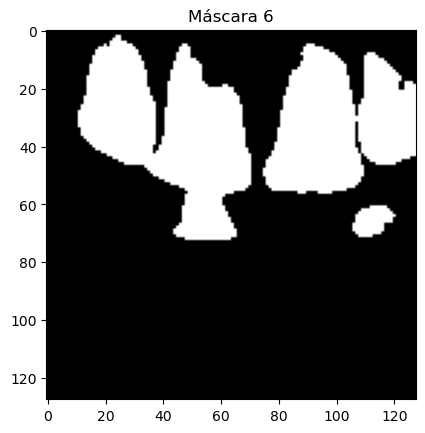

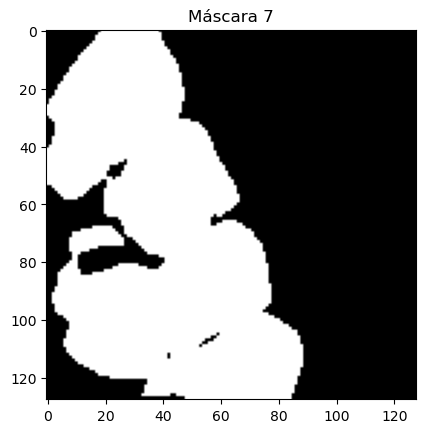

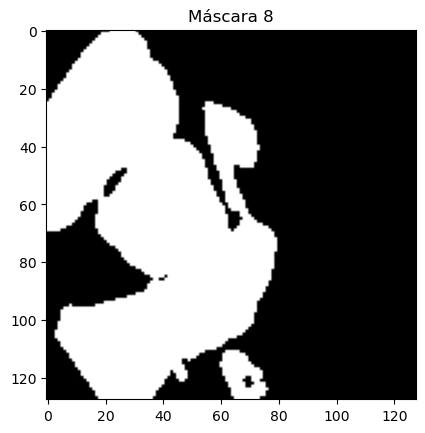

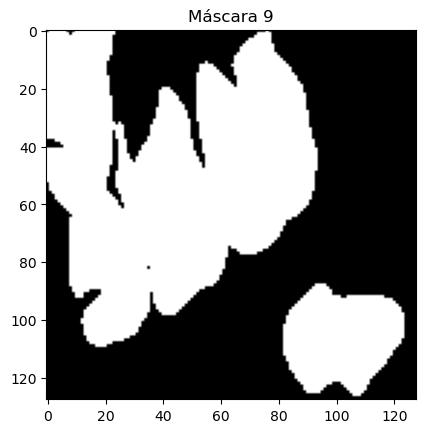

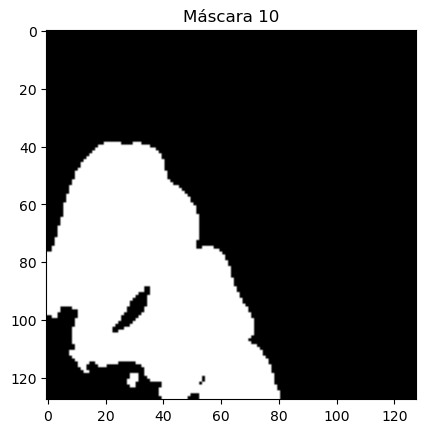

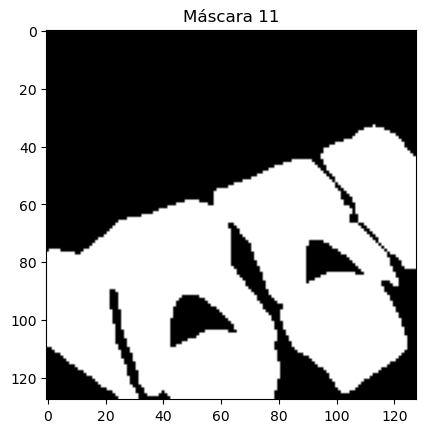

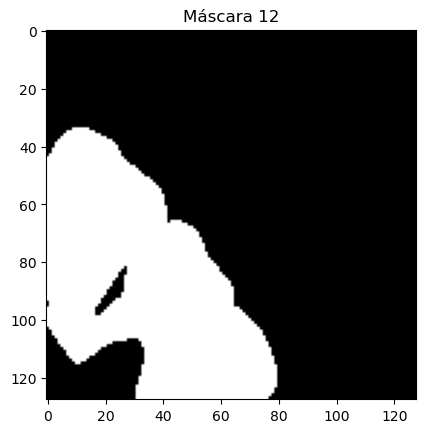

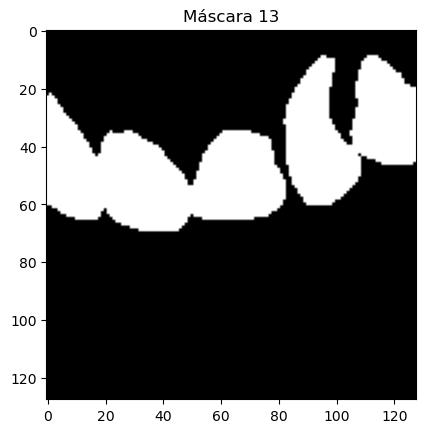

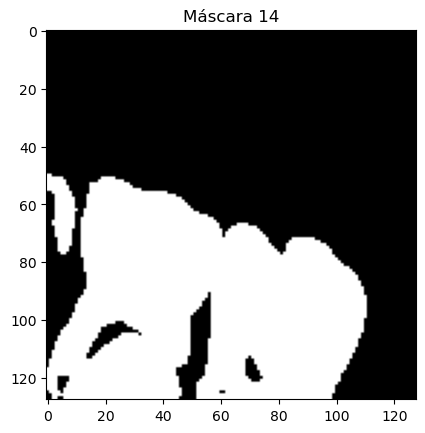

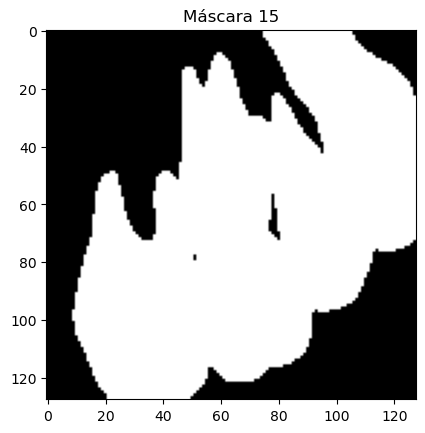

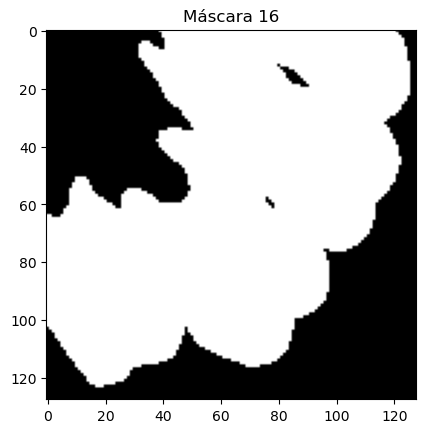

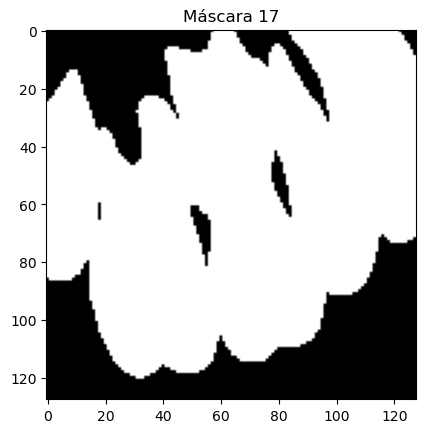

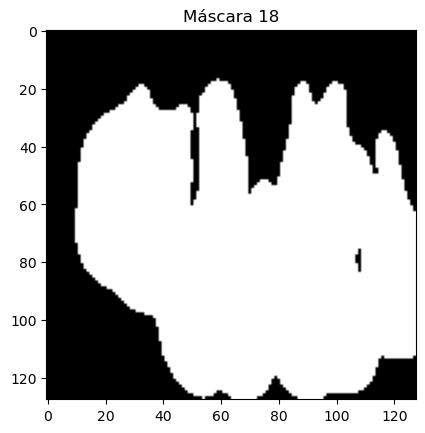

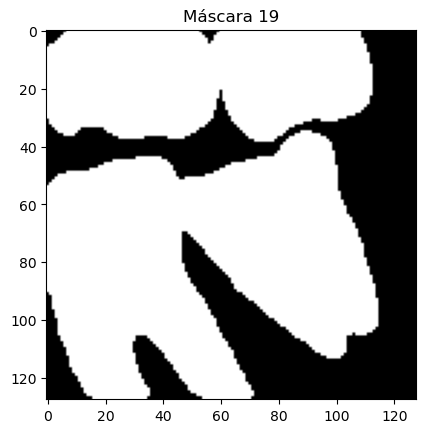

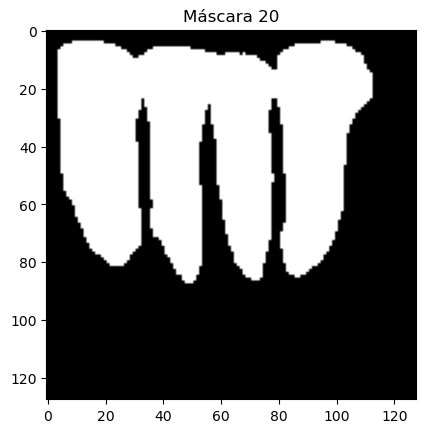

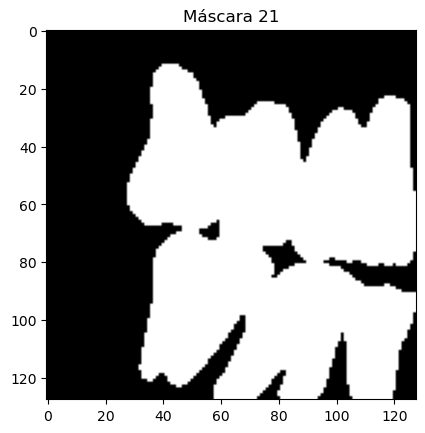

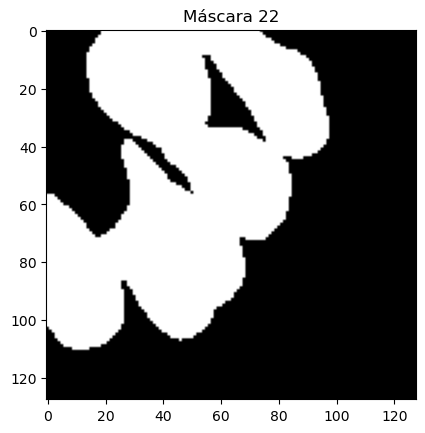

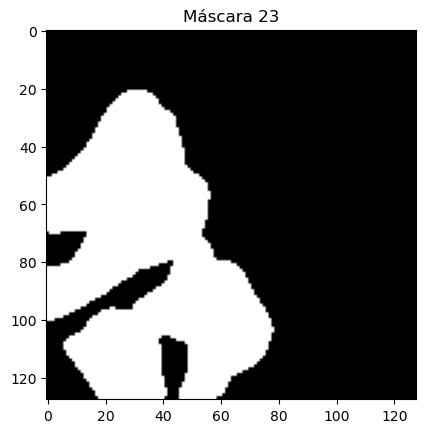

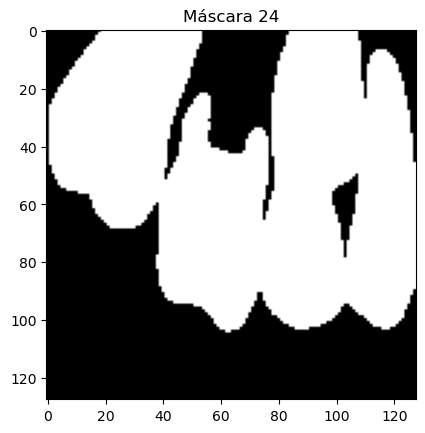

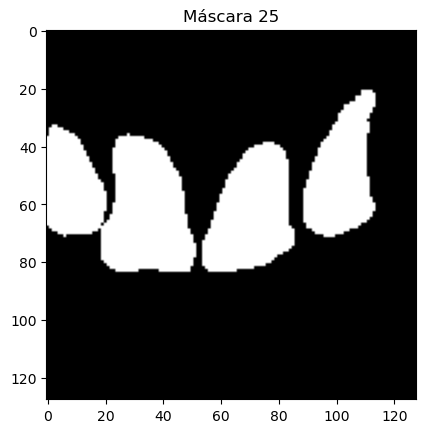

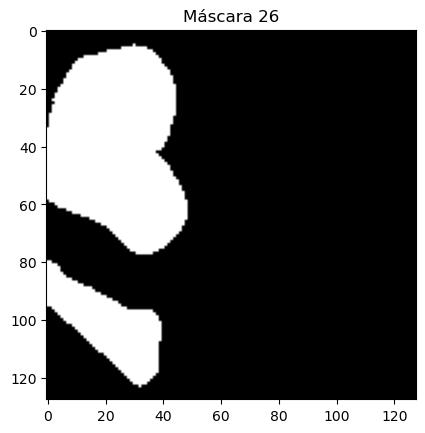

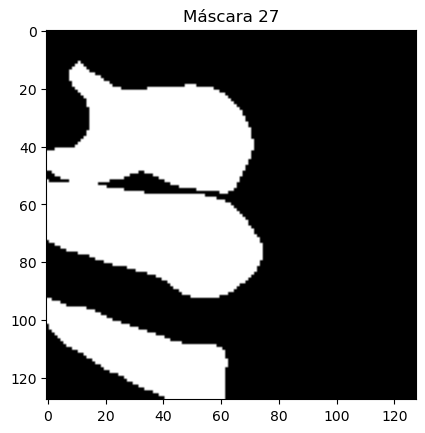

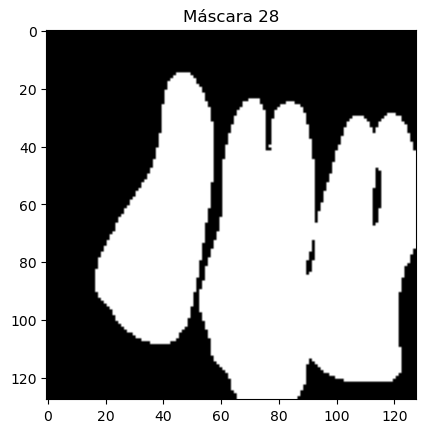

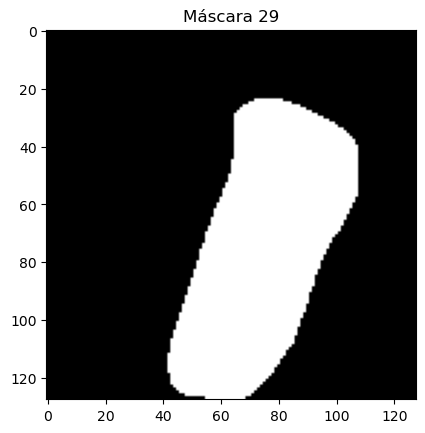

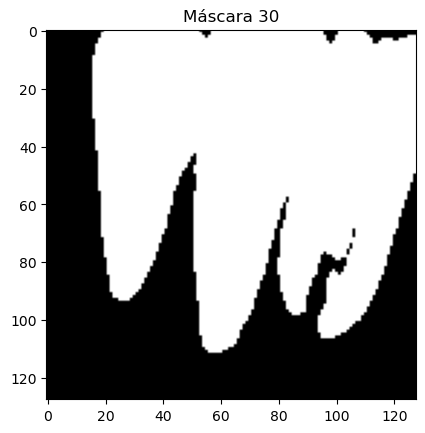

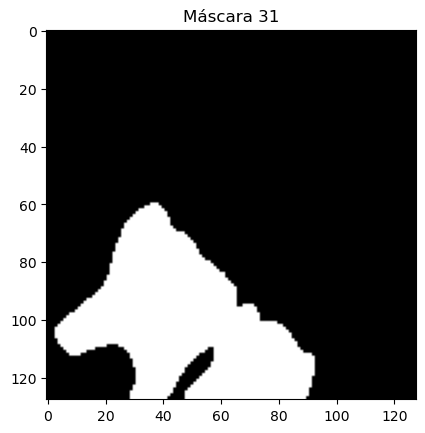

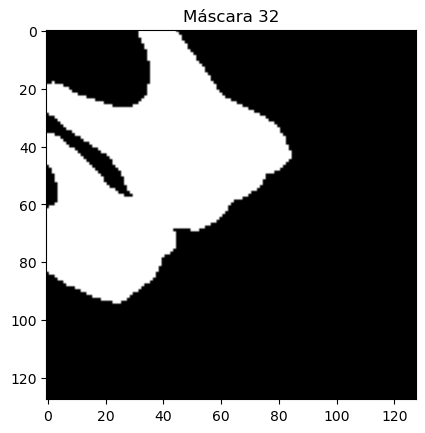

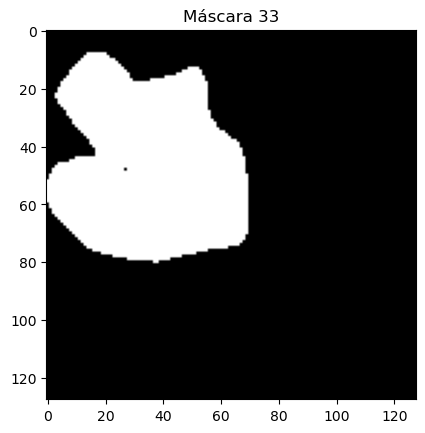

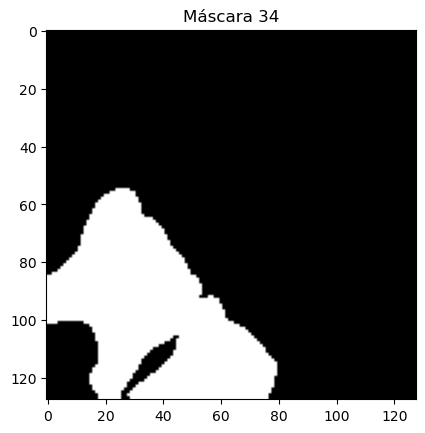

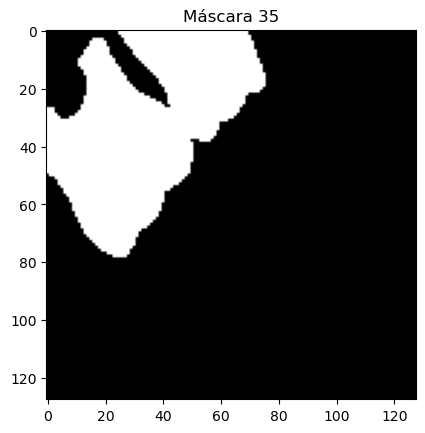

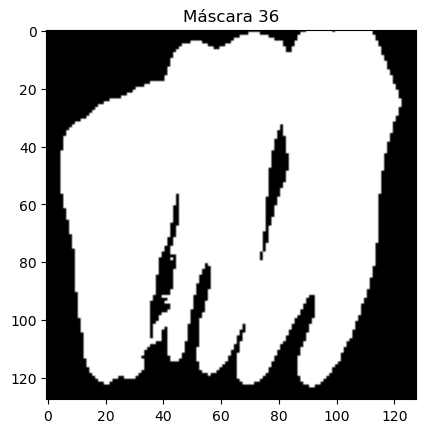

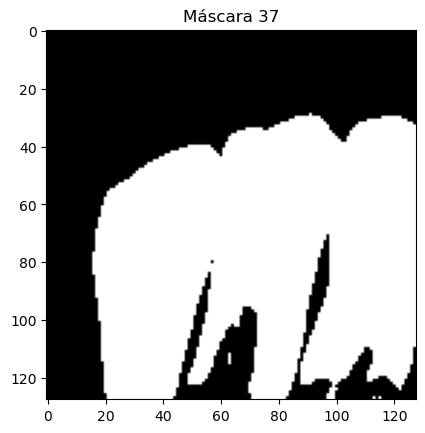

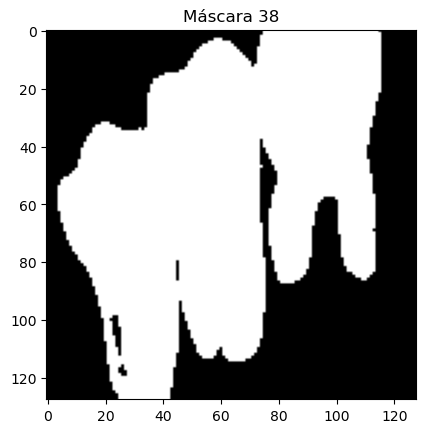

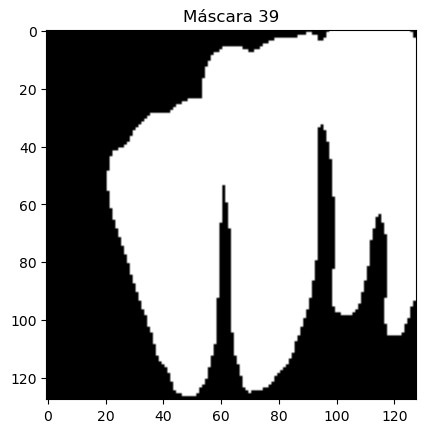

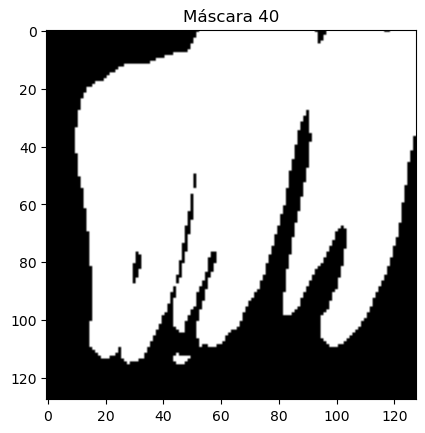

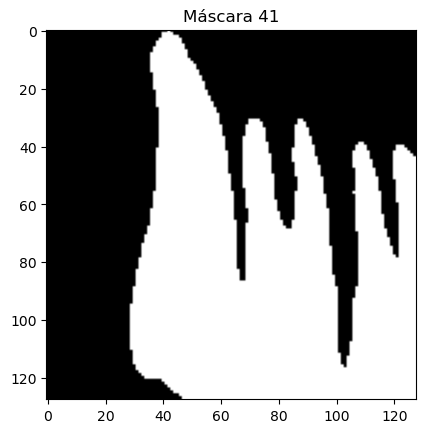

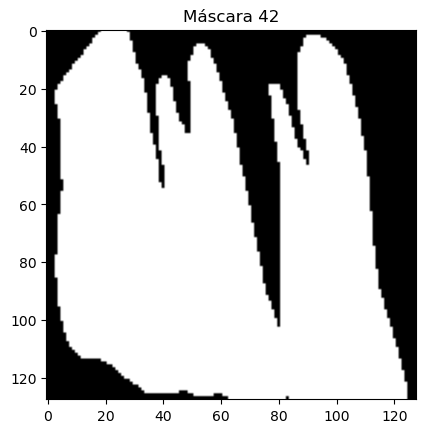

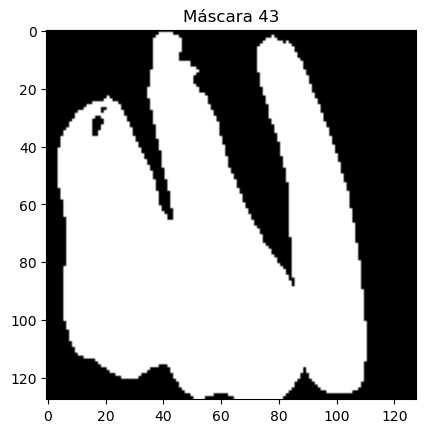

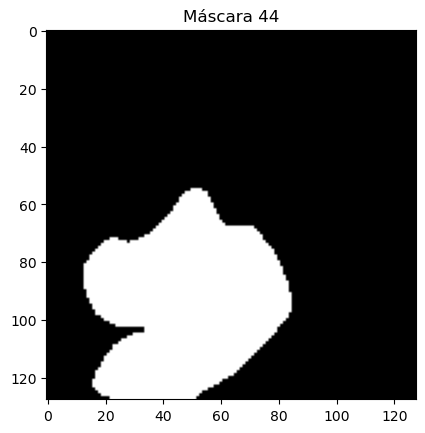

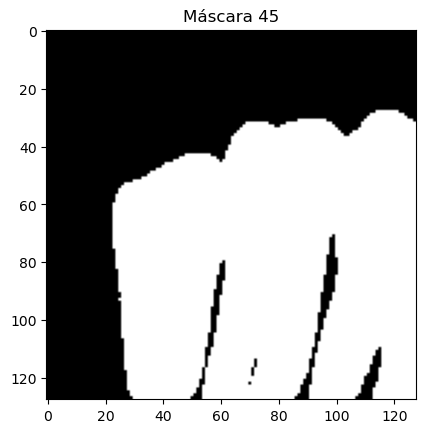

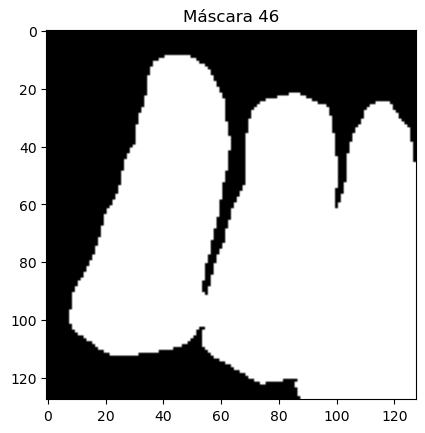

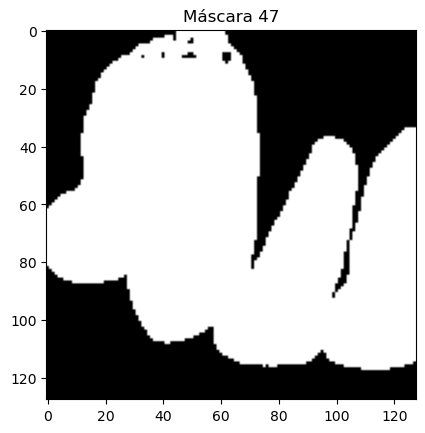

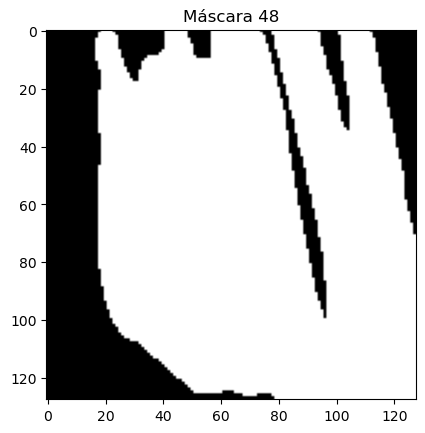

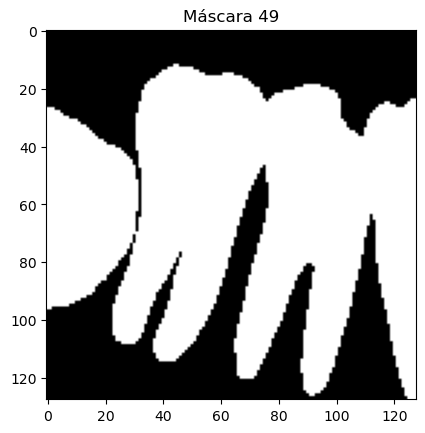

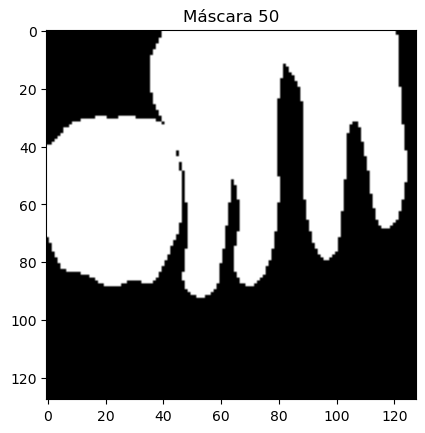

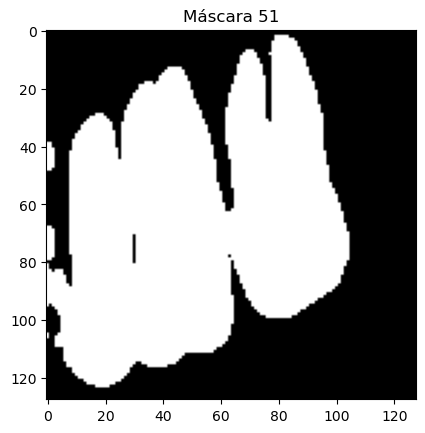

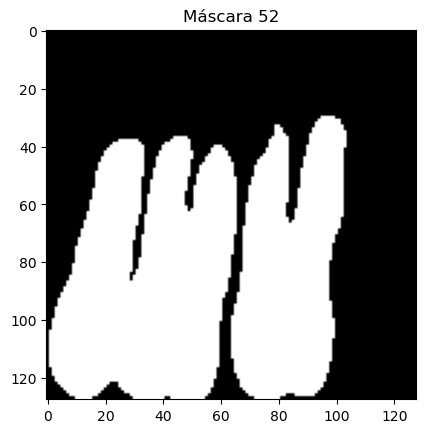

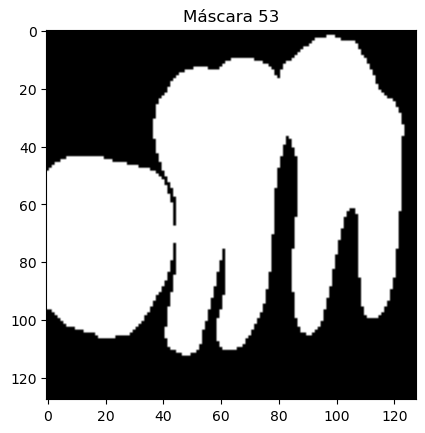

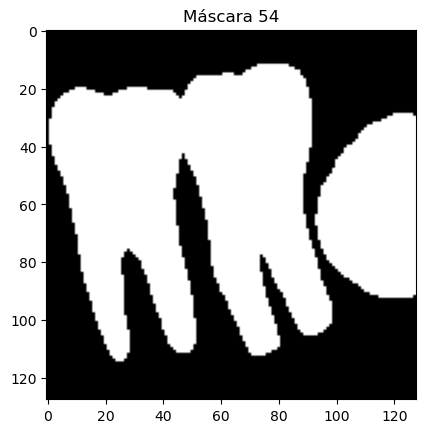

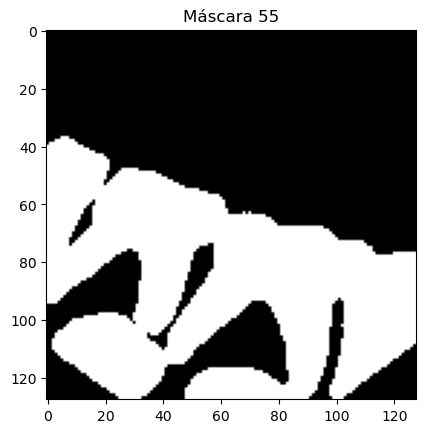

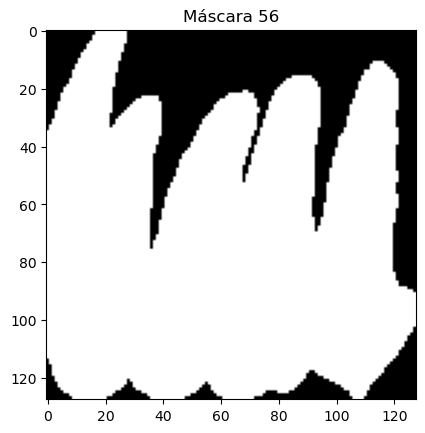

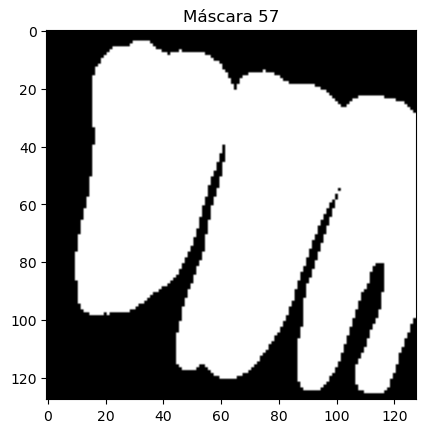

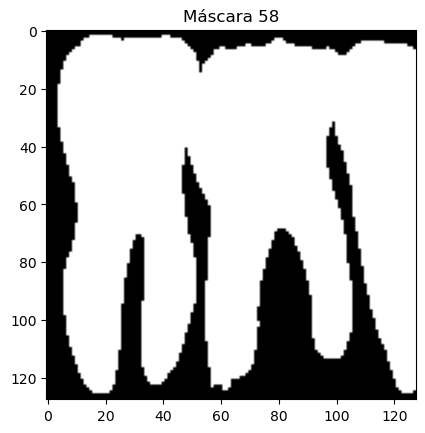

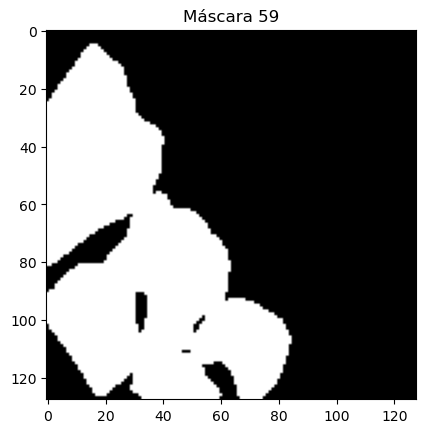

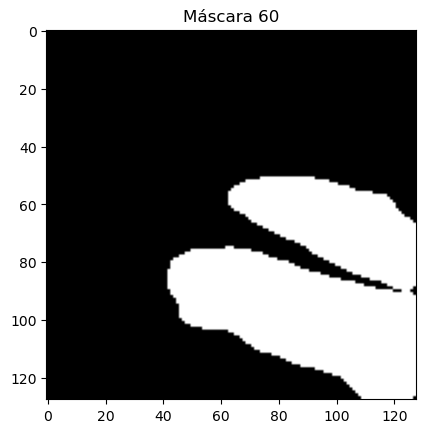

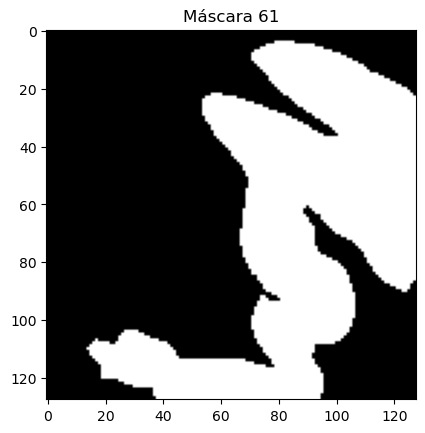

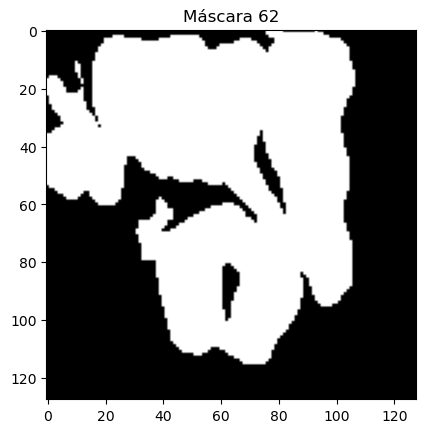

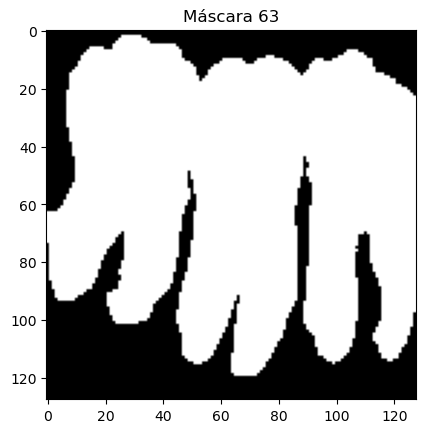

In [6]:
import os
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
import cv2  # Para guardar las imágenes en formato adecuado
from skimage.io import imsave  # Para guardar las imágenes

# Cargar el modelo
model = load_model("unet3_modelo")

# Asegúrate de que exista la carpeta "mascaras3_modelo" para guardar las imágenes
output_folder = "mascaras3_modelo"
os.makedirs(output_folder, exist_ok=True)

# Realizar predicciones
preds = model.predict(X_test, batch_size=1)

# Binarizar y guardar las predicciones como imágenes
for i in range(len(X_test)):
    # Squeeze para quitar dimensiones innecesarias y convertir a escala binaria
    pred_mask = np.squeeze(preds[i])
    
    # Binarizar la imagen: todo lo que esté por encima de un umbral será 1 (blanco), el resto será 0 (negro)
    binary_mask = (pred_mask > 0.5).astype(np.uint8) * 255  # Convierte a 0 y 255

    # Guardar la máscara binarizada
    output_path = os.path.join(output_folder, f"mascara_{i}.png")
    
    # Guardar la imagen binaria en blanco y negro
    imsave(output_path, binary_mask)

    # Mostrar la imagen binaria (opcional)
    plt.imshow(binary_mask, cmap='gray')
    plt.title(f'Máscara {i}')
    plt.show()

# Este código guarda las máscaras en la carpeta "mascaras3_modelo" y las muestra como imágenes en blanco y negro.


In [23]:
import cv2
import numpy as np
import os

def standardize_image(image, target_size):
    """
    Redimensiona la imagen a un tamaño objetivo.
    
    Parámetros:
    image: np.array
        Imagen a redimensionar.
    target_size: tuple
        Tamaño objetivo (ancho, alto).
    
    Retorna:
    np.array
        Imagen redimensionada.
    """
    return cv2.resize(image, target_size, interpolation=cv2.INTER_NEAREST)

def extract_teeth_from_folder(images_folder, masks_folder, output_folder, target_size=(512, 512)):
    """
    Extrae dientes individuales de imágenes en una carpeta usando máscaras de otra carpeta.
    
    Parámetros:
    images_folder: str
        Ruta de la carpeta que contiene las imágenes originales.
    masks_folder: str
        Ruta de la carpeta que contiene las máscaras binarias de los dientes segmentados.
    output_folder: str
        Carpeta donde se guardarán las imágenes de los dientes extraídos.
    target_size: tuple
        Tamaño objetivo para redimensionar las imágenes y máscaras (ancho, alto).
    """
    # Comprobar que el directorio de salida existe
    os.makedirs(output_folder, exist_ok=True)

    # Listar todos los archivos en la carpeta de imágenes
    image_files = sorted(os.listdir(images_folder))
    mask_files = sorted(os.listdir(masks_folder))

    # Verificar que ambos directorios tengan la misma cantidad de archivos
    if len(image_files) != len(mask_files):
        print("Error: La cantidad de imágenes y máscaras no coincide.")
        return

    # Procesar cada imagen y su correspondiente máscara
    for image_file, mask_file in zip(image_files, mask_files):
        # Crear las rutas completas de cada archivo
        image_path = os.path.join(images_folder, image_file)
        mask_path = os.path.join(masks_folder, mask_file)

        # Cargar la imagen y la máscara
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Cargar como escala de grises

        # Estandarizar imagen y máscara
        image = standardize_image(image, target_size)
        mask = standardize_image(mask, target_size)

        # Asegurarse de que la máscara sea binaria
        _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

        # Encontrar los contornos de los objetos en la máscara binaria
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Extraer y guardar cada diente
        for i, contour in enumerate(contours):
            # Crear una máscara vacía para cada diente
            tooth_mask = np.zeros_like(binary_mask)

            # Dibujar el contorno del diente en la máscara
            cv2.drawContours(tooth_mask, contours, i, 255, thickness=cv2.FILLED)

            # Asegurarse de que tooth_mask sea del tipo correcto
            tooth_mask = tooth_mask.astype(np.uint8)

            # Extraer el diente de la imagen original utilizando la máscara
            tooth = cv2.bitwise_and(image, image, mask=tooth_mask)

            # Encontrar el bounding box para recortar el diente
            x, y, w, h = cv2.boundingRect(contour)
            tooth_cropped = tooth[y:y+h, x:x+w]

            # Guardar el diente extraído
            tooth_filename = os.path.join(output_folder, f'{os.path.splitext(image_file)[0]}_tooth_{i+1}.png')
            cv2.imwrite(tooth_filename, tooth_cropped)
            print(f"Guardado: {tooth_filename}")

# Ejemplo de uso
images_folder = 'test'  # Ruta a la carpeta de imágenes originales
masks_folder = 'MascarasOriginales'  # Ruta a la carpeta de máscaras
output_folder = 'sePudo'  # Carpeta donde guardar los dientes extraídos

extract_teeth_from_folder(images_folder, masks_folder, output_folder, target_size=(512, 512))


Guardado: sePudo\diente1_tooth_1.png
Guardado: sePudo\diente10_tooth_1.png
Guardado: sePudo\diente10_tooth_2.png
Guardado: sePudo\diente11_tooth_1.png
Guardado: sePudo\diente11_tooth_2.png
Guardado: sePudo\diente11_tooth_3.png
Guardado: sePudo\diente11_tooth_4.png
Guardado: sePudo\diente12_tooth_1.png
Guardado: sePudo\diente12_tooth_2.png
Guardado: sePudo\diente13_tooth_1.png
Guardado: sePudo\diente13_tooth_2.png
Guardado: sePudo\diente13_tooth_3.png
Guardado: sePudo\diente13_tooth_4.png
Guardado: sePudo\diente14_tooth_1.png
Guardado: sePudo\diente15_tooth_1.png
Guardado: sePudo\diente16_tooth_1.png
Guardado: sePudo\diente17_tooth_1.png
Guardado: sePudo\diente17_tooth_2.png
Guardado: sePudo\diente18_tooth_1.png
Guardado: sePudo\diente18_tooth_2.png
Guardado: sePudo\diente19_tooth_1.png
Guardado: sePudo\diente2_tooth_1.png
Guardado: sePudo\diente2_tooth_2.png
Guardado: sePudo\diente20_tooth_1.png
Guardado: sePudo\diente21_tooth_1.png
Guardado: sePudo\diente22_tooth_1.png
Guardado: sePud

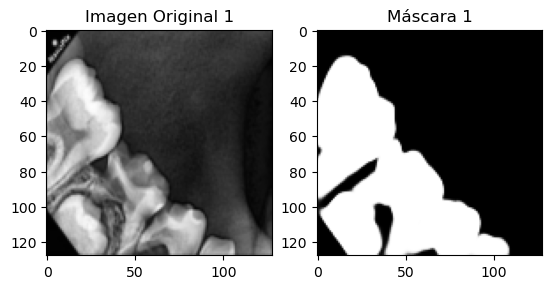

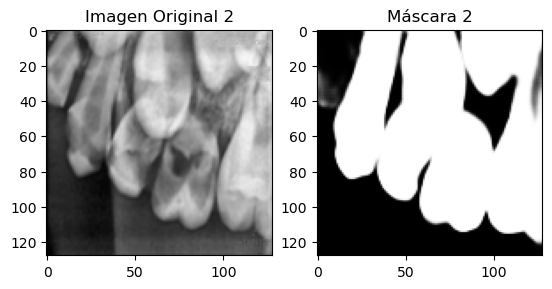

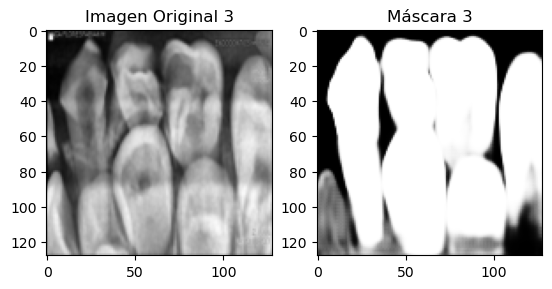

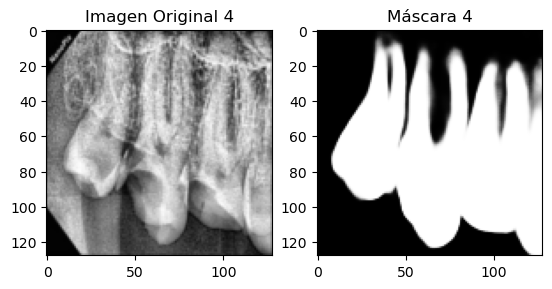

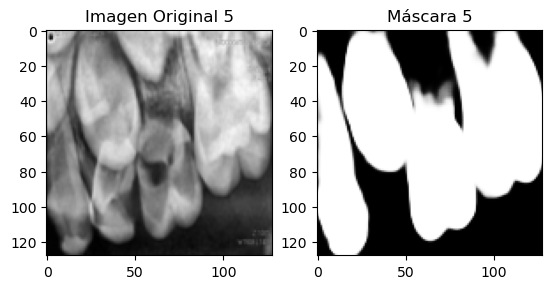

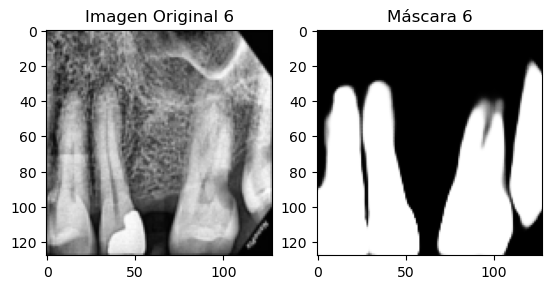

In [16]:
import os
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np

# Cargar el modelo
model = load_model("unet3_modelo")

# Crear la carpeta "nuevas mascaras" si no existe
output_dir = "nuevas_mascaras"
os.makedirs(output_dir, exist_ok=True)

# Crear la carpeta "OriginalRadio" si no existe
originals_dir = "OriginalRadio"
os.makedirs(originals_dir, exist_ok=True)

# Hacer predicciones y guardar las máscaras y las imágenes originales
for i in range(len("X_test")):
    # Predecir para una sola imagen
    img = X_test[i]
    
    # Convertir a RGB si es necesario
    if img.shape[-1] == 1:  # Imagen en escala de grises
        img = np.concatenate([img, img, img], axis=-1)  # Duplicar el canal
    
    preds = model.predict(img[np.newaxis, ...])  # Predecir con forma (1, height, width, channels)
    mask = np.squeeze(preds)  # Eliminar dimensiones innecesarias

    # Guardar la máscara
    mask_filename = os.path.join(output_dir, f"diente_{i + 1}.jpeg")
    plt.imsave(mask_filename, mask, cmap='gray')
    
    # Guardar la imagen original
    original_filename = os.path.join(originals_dir, f"original_{i + 1}.jpeg")
    plt.imsave(original_filename, img, cmap='gray')
    
    # Mostrar la imagen original y la máscara (opcional)
    plt.subplot(1, 2, 1)
    plt.imshow(np.squeeze(X_test[i]), cmap='gray')
    plt.title(f'Imagen Original {i + 1}')
    
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title(f'Máscara {i + 1}')
    
    plt.show()


In [18]:
import os
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread  # Usamos skimage para cargar las imágenes desde la carpeta

# Especificar la ruta de la carpeta de imágenes
image_dir = r"D:\10decimoCiclo\Capstone\modelos\PruebaU-net\Semantic-Segmentation-Basic-U-Net\OriginalRadio"  # Cambia esto a la ruta de tu carpeta de imágenes

# Obtener las rutas de todas las imágenes en la carpeta
image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith('.jpeg')]

# Cargar el modelo
model = load_model("unet3_modelo")

# Crear la carpeta "nuevas mascaras" si no existe
output_dir = "nuevas_mascaras"
os.makedirs(output_dir, exist_ok=True)

# Crear la carpeta "OriginalRadio" si no existe
originals_dir = "OriginalRadio"
os.makedirs(originals_dir, exist_ok=True)

# Hacer predicciones y guardar las máscaras y las imágenes originales
for i, img_path in enumerate(image_paths):
    # Cargar la imagen
    img = imread(img_path)
    
    # Convertir a RGB si es necesario
    if img.shape[-1] == 1:  # Imagen en escala de grises
        img = np.concatenate([img, img, img], axis=-1)  # Duplicar el canal
    
    preds = model.predict(img[np.newaxis, ...])  # Predecir con forma (1, height, width, channels)
    mask = np.squeeze(preds)  # Eliminar dimensiones innecesarias

    # Guardar la máscara
    mask_filename = os.path.join(output_dir, f"diente_{i + 1}.jpeg")
    plt.imsave(mask_filename, mask, cmap='gray')
    
    # Guardar la imagen original
    original_filename = os.path.join(originals_dir, f"original_{i + 1}.jpeg")
    plt.imsave(original_filename, img, cmap='gray')
    
    # Mostrar la imagen original y la máscara (opcional)
    plt.subplot(1, 2, 1)
    plt.imshow(np.squeeze(img), cmap='gray')
    plt.title(f'Imagen Original {i + 1}')
    
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title(f'Máscara {i + 1}')
    
    plt.show()


ValueError: Error when checking input: expected input_1 to have 4 dimensions, but got array with shape (1, 640, 884)

Forma de preds: (62, 128, 128, 1)
Forma de y_true: (62, 128, 128, 1)
Proporción de píxeles positivos en y_true: 0.4945
Proporción de píxeles positivos en preds: 0.5617
Precisión (en umbral 0.5): 0.4945
Recall (en umbral 0.5): 1.0000
F1-score máximo: 0.6624
AUC: 0.5539


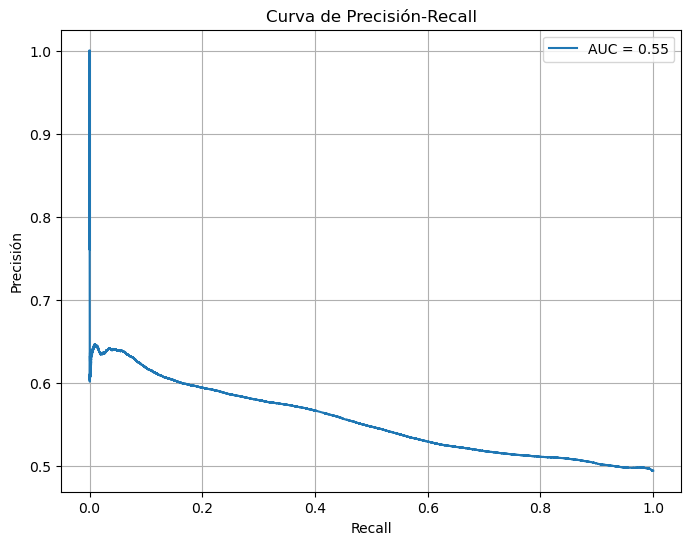

In [19]:
import os
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from skimage.io import imread_collection
from skimage.transform import resize
from sklearn.metrics import precision_recall_curve, auc

def evaluar_modelo(model_path, X_test, mask_folder, threshold=0.5):
    # Cargar el modelo
    model = load_model(model_path)

    # Realizar predicciones
    preds = model.predict(X_test, batch_size=1)

    # Cargar las máscaras verdaderas
    mask_files = os.path.join(mask_folder, '*.jpeg')
    y_true = imread_collection(mask_files)

    if len(y_true) == 0:
        raise ValueError(f"No se encontraron archivos de máscara en {mask_folder}")

    # Convertir a un array de NumPy y redimensionar
    y_true = np.array([resize(mask, (preds.shape[1], preds.shape[2]), anti_aliasing=True, preserve_range=True) for mask in y_true])

    # Asegurarse de que y_true tenga la forma (n_samples, height, width, channels)
    if y_true.ndim == 3:
        y_true = y_true[:, :, :, np.newaxis]

    # Binarizar las máscaras verdaderas (asegúrate de que la binarización sea coherente)
    y_true_bin = (y_true > 0.5).astype(np.float32)  # Ajustar umbral si es necesario

    # Verificar las formas de los arrays
    print(f"Forma de preds: {preds.shape}")
    print(f"Forma de y_true: {y_true.shape}")

    # Umbralizar las predicciones
    preds_bin = (preds > threshold).astype(np.float32)

    # Aplanar las matrices
    preds_flat = preds_bin.flatten()
    y_true_flat = y_true_bin.flatten()

    # Verificar si hay un balance adecuado entre positivos y negativos
    print(f"Proporción de píxeles positivos en y_true: {np.mean(y_true_flat):.4f}")
    print(f"Proporción de píxeles positivos en preds: {np.mean(preds_flat):.4f}")

    # Calcular la curva de precisión-recall
    precision, recall, thresholds = precision_recall_curve(y_true_flat, preds.flatten())  # Comparar contra predicciones originales

    # Calcular el AUC
    auc_score = auc(recall, precision)

    # Calcular F1 score
    f1_scores = 2 * (precision * recall) / (precision + recall)
    f1_scores = f1_scores[~np.isnan(f1_scores)]
    f1_score = np.max(f1_scores)

    # Mostrar las métricas
    print(f"Precisión (en umbral {threshold}): {precision[np.argmax(recall)]:.4f}")
    print(f"Recall (en umbral {threshold}): {recall[np.argmax(recall)]:.4f}")
    print(f"F1-score máximo: {f1_score:.4f}")
    print(f"AUC: {auc_score:.4f}")

    # Graficar la curva de precisión-recall
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'AUC = {auc_score:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precisión')
    plt.title('Curva de Precisión-Recall')
    plt.legend()
    plt.grid(True)
    plt.show()

# Solicitar la ruta del modelo y de la carpeta con las máscaras verdaderas
model_path = "unet2_modelo"
mask_folder = "MascarasTest"

# Evaluar el modelo
# Asegúrate de que X_test esté cargado correctamente antes de llamar a esta función
# X_test = ...  # Aquí deberías cargar tu conjunto de prueba

evaluar_modelo(model_path, X_test, mask_folder)


Processing images in test: 100%|███████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.55it/s]


X_test shape: (62, 128, 128, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


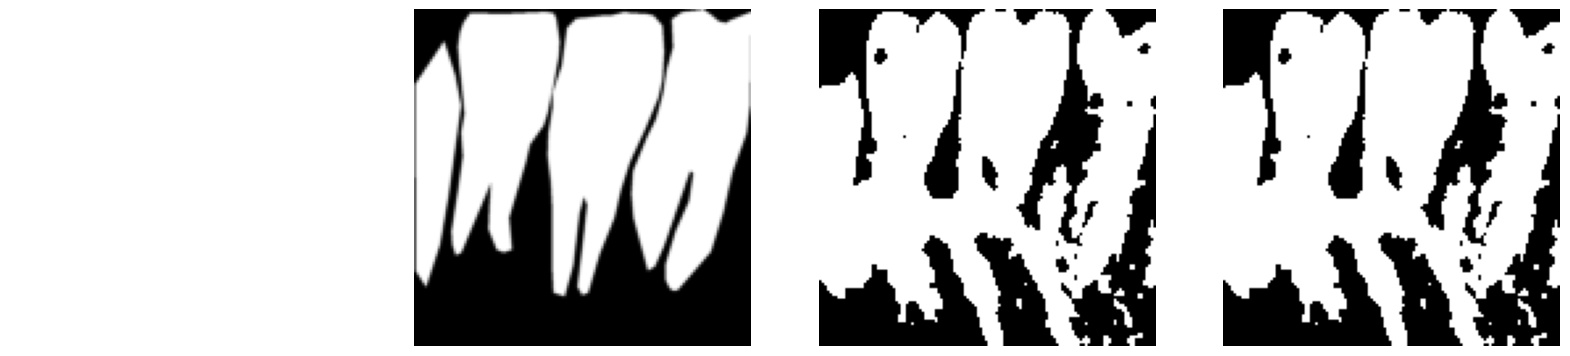

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


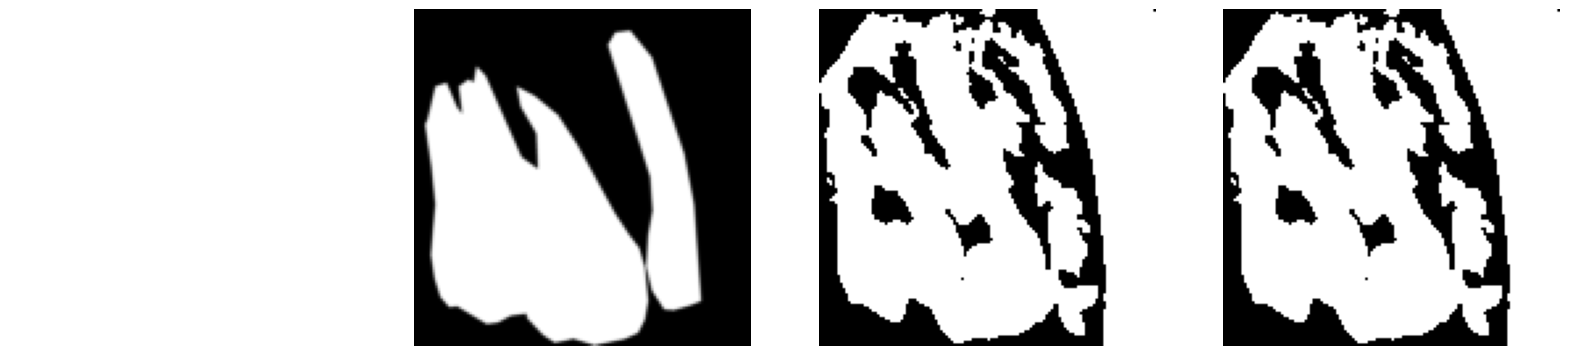

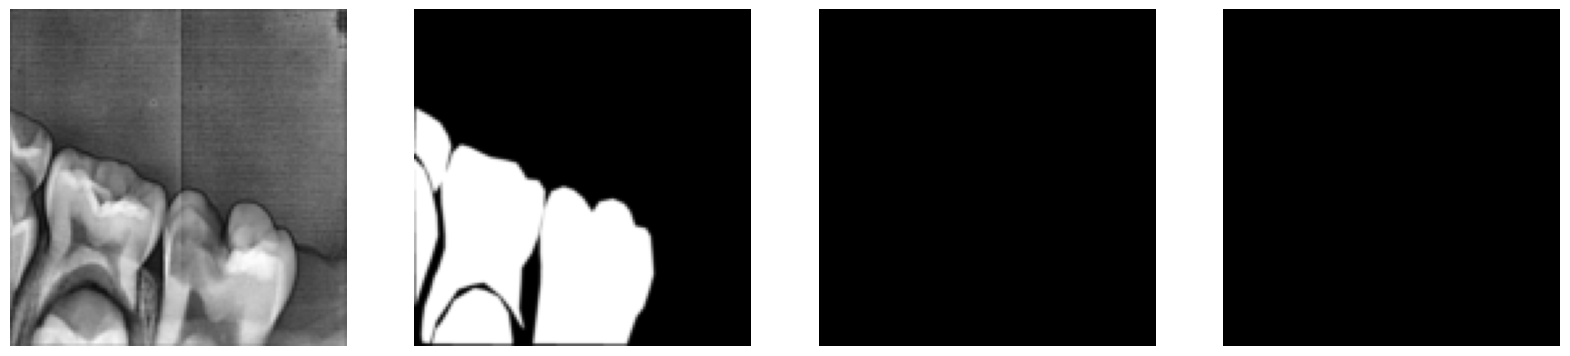

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


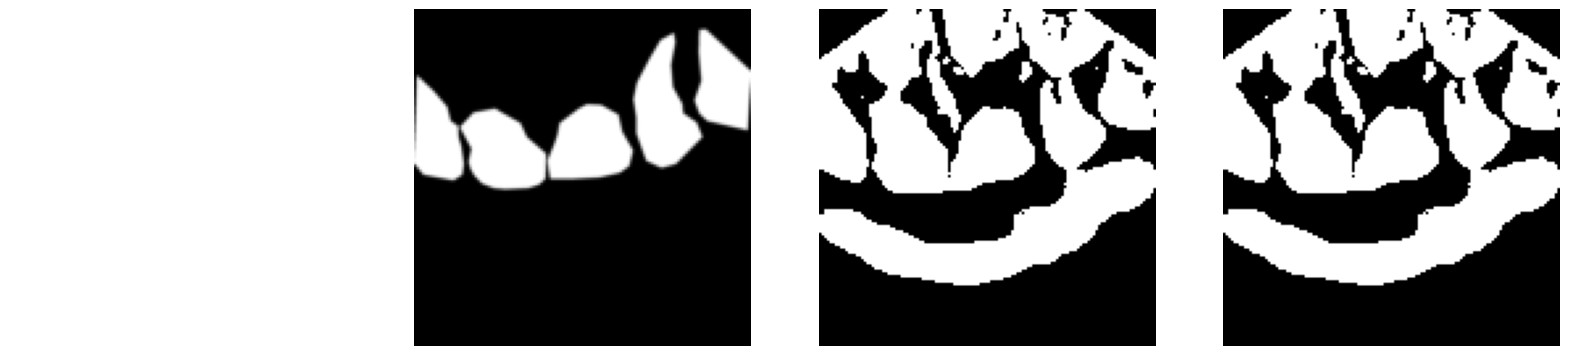

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


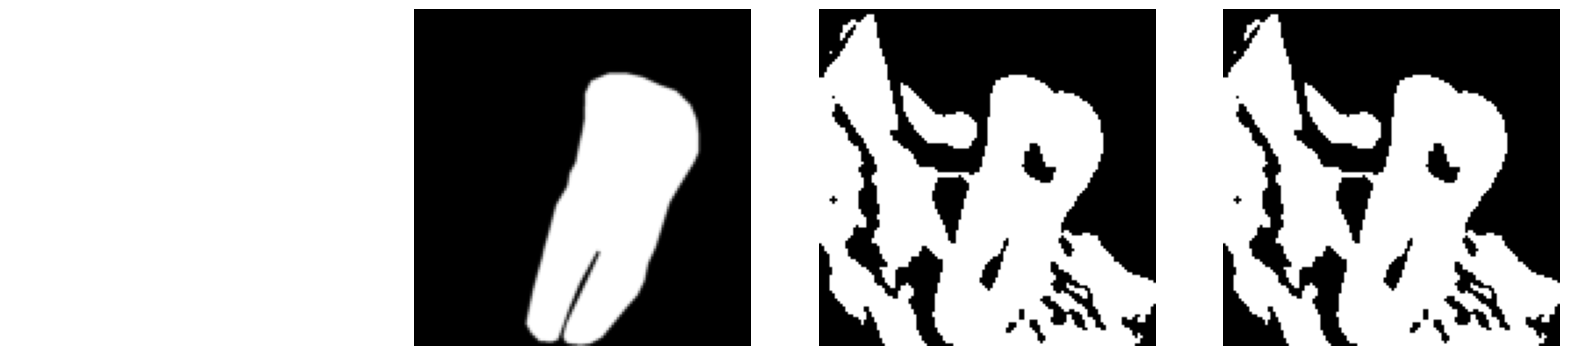

Umbral: 0.10, Precisión: 0.7327, Recall: 0.8392, F1-score: 0.7823, AUC-PR: 0.8581
Umbral: 0.20, Precisión: 0.7327, Recall: 0.8392, F1-score: 0.7823, AUC-PR: 0.8581
Umbral: 0.30, Precisión: 0.7327, Recall: 0.8392, F1-score: 0.7823, AUC-PR: 0.8581
Umbral: 0.40, Precisión: 0.7327, Recall: 0.8392, F1-score: 0.7823, AUC-PR: 0.8581
Umbral: 0.50, Precisión: 0.7327, Recall: 0.8392, F1-score: 0.7823, AUC-PR: 0.8581
Umbral: 0.60, Precisión: 0.7327, Recall: 0.8392, F1-score: 0.7823, AUC-PR: 0.8581
Umbral: 0.70, Precisión: 0.7327, Recall: 0.8392, F1-score: 0.7823, AUC-PR: 0.8581
Umbral: 0.80, Precisión: 0.7327, Recall: 0.8392, F1-score: 0.7823, AUC-PR: 0.8581
Umbral: 0.90, Precisión: 0.7327, Recall: 0.8392, F1-score: 0.7823, AUC-PR: 0.8581


In [23]:
import os
import numpy as np
import re
from tqdm import tqdm
from skimage.io import imread
from skimage.color import gray2rgb, rgb2gray
from skimage.transform import resize
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
import random

def extraer_numero(nombre_archivo):
    """Extrae el número del nombre del archivo."""
    match = re.search(r'\d+', nombre_archivo)
    return int(match.group()) if match else float('inf')

def cargar_imagenes_ordenadas(folder_path, target_shape=(128, 128)):
    """Carga y ordena las imágenes desde una carpeta por el número en su nombre."""
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpeg', '.jpg', '.png'))]
    image_files.sort(key=extraer_numero)
    
    images = []
    for file in tqdm(image_files, desc=f"Processing images in {folder_path}"):
        img = imread(os.path.join(folder_path, file))
        
        # Convertir a escala de grises primero para manejar imágenes inhomogéneas
        if img.ndim == 3 and img.shape[2] == 3:
            img = rgb2gray(img)
        
        # Convertir de nuevo a RGB
        img = gray2rgb(img)
        
        img = resize(img, target_shape, mode='constant', preserve_range=True)
        images.append(img)
    return np.array(images), image_files

def calcular_metricas(preds, y_true, umbrales=np.linspace(0.1, 0.9, 9)):
    resultados = []
    for threshold in umbrales:
        preds_bin = (preds > threshold).astype(np.float32)
        precision, recall, _ = precision_recall_curve(y_true.flatten(), preds.flatten())
        f1_scores = 2 * (precision * recall) / (precision + recall)
        f1_score = np.max(f1_scores[~np.isnan(f1_scores)])
        auc_score = auc(recall, precision)

        resultados.append({
            'Umbral': threshold,
            'Precisión': precision[np.argmax(f1_scores)],
            'Recall': recall[np.argmax(f1_scores)],
            'F1-score': f1_score,
            'AUC-PR': auc_score
        })
    return resultados

def evaluar_modelo(model_path, X_test_images, mask_folder, num_examples=5):
    model = load_model(model_path)
    mask_files = [os.path.join(mask_folder, f) for f in os.listdir(mask_folder) if f.endswith(('.jpeg', '.jpg', '.png'))]
    mask_files.sort(key=extraer_numero)
    y_true = np.array([resize(imread(mask), (X_test_images.shape[1], X_test_images.shape[2]), anti_aliasing=True, preserve_range=True) for mask in mask_files])

    preds = model.predict(X_test_images, batch_size=1)
    y_true_bin = (y_true > 0.5).astype(np.float32)
    resultados = calcular_metricas(preds, y_true_bin)

    indices = random.sample(range(len(y_true)), num_examples)
    for i in indices:
        plt.figure(figsize=(20, 5))
        plt.subplot(1, 4, 1)
        plt.imshow(X_test_images[i].squeeze())
        plt.axis('off')

        plt.subplot(1, 4, 2)
        plt.imshow(y_true[i].squeeze(), cmap='gray')
        plt.axis('off')

        plt.subplot(1, 4, 3)
        plt.imshow(preds[i].squeeze() > 0.5, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 4, 4)
        plt.imshow((preds[i].squeeze() > 0.5).astype(np.float32), cmap='gray')
        plt.axis('off')

        plt.show()

    return resultados

# Cargar las imágenes de prueba y sus nombres
model_path = "unet_modelo"
mask_folder = "MascarasTest"
test_folder = "test"
X_test, X_test_filenames = cargar_imagenes_ordenadas(test_folder, target_shape=(128, 128))
print('X_test shape:', X_test.shape)

# Evaluar el modelo
resultados = evaluar_modelo(model_path, X_test, mask_folder, num_examples=5)
for resultado in resultados:
    print(f"Umbral: {resultado['Umbral']:.2f}, Precisión: {resultado['Precisión']:.4f}, Recall: {resultado['Recall']:.4f}, F1-score: {resultado['F1-score']:.4f}, AUC-PR: {resultado['AUC-PR']:.4f}")


In [27]:
from tensorflow.keras import backend as K

K.clear_session()
